# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [10]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.393702
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Classifier has initially no knowledge of data it will be classifying, so the probability of classifying given sample as an instance of any of C classes is 1/C (here 0.1). Softmax transforms scores to values that can be represented as probabilites. Weights are initially set at random thus small differences from expected value are very likely.*


In [50]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.472078 analytic: -2.472078, relative error: 3.019742e-09
numerical: 1.580447 analytic: 1.580447, relative error: 8.832478e-09
numerical: 2.694756 analytic: 2.694756, relative error: 1.694637e-08
numerical: 1.950125 analytic: 1.950125, relative error: 1.335345e-08
numerical: 0.558191 analytic: 0.558191, relative error: 7.150936e-08
numerical: -0.764298 analytic: -0.764298, relative error: 2.852595e-08
numerical: 0.102410 analytic: 0.102409, relative error: 1.743831e-07
numerical: 0.548510 analytic: 0.548510, relative error: 4.400031e-08
numerical: -0.186663 analytic: -0.186663, relative error: 4.953582e-08
numerical: -0.195586 analytic: -0.195586, relative error: 2.263244e-07
numerical: -0.470785 analytic: -0.470785, relative error: 4.284455e-08
numerical: 5.136394 analytic: 5.136394, relative error: 2.047240e-08
numerical: 1.677668 analytic: 1.677668, relative error: 4.926245e-08
numerical: 0.988206 analytic: 0.988206, relative error: 9.169239e-09
numerical: -2.099311 ana

In [51]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.393711e+00 computed in 0.136102s
vectorized loss: 2.393711e+00 computed in 0.005004s
Loss difference: 0.000000
Gradient difference: 0.000000


In [58]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [0.08e-7,0.1e-7,0.15e-7,0.25e-7]
regularization_strengths = [0.8e4,1.0e4,1.25e4,1.5e4,2e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_iters=15000

for l in learning_rates:
    for r in regularization_strengths:
        print("for r=",r," and l=",l)
        softmax = Softmax()

        softmax.train(X_train, y_train, learning_rate=l, reg=r,
                              num_iters=num_iters, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy=np.mean(y_val == y_val_pred)
        results[(l,r)]=(training_accuracy,validation_accuracy) 
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
            
        print()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

for r= 8000.0  and l= 8e-09
iteration 0 / 15000: loss 252.752123
iteration 100 / 15000: loss 246.552040
iteration 200 / 15000: loss 239.391816
iteration 300 / 15000: loss 233.237623
iteration 400 / 15000: loss 227.606876
iteration 500 / 15000: loss 221.615816
iteration 600 / 15000: loss 215.715174
iteration 700 / 15000: loss 210.157642
iteration 800 / 15000: loss 204.866536
iteration 900 / 15000: loss 199.655359
iteration 1000 / 15000: loss 194.462495
iteration 1100 / 15000: loss 189.570276
iteration 1200 / 15000: loss 184.496915
iteration 1300 / 15000: loss 180.328052
iteration 1400 / 15000: loss 175.934977
iteration 1500 / 15000: loss 171.203208
iteration 1600 / 15000: loss 166.968648
iteration 1700 / 15000: loss 162.647116
iteration 1800 / 15000: loss 158.097033
iteration 1900 / 15000: loss 154.727297
iteration 2000 / 15000: loss 150.682042
iteration 2100 / 15000: loss 146.885257
iteration 2200 / 15000: loss 143.260869
iteration 2300 / 15000: loss 139.549521
iteration 2400 / 15000: 

iteration 5700 / 15000: loss 51.630864
iteration 5800 / 15000: loss 50.110574
iteration 5900 / 15000: loss 48.611757
iteration 6000 / 15000: loss 47.080420
iteration 6100 / 15000: loss 45.587756
iteration 6200 / 15000: loss 44.293922
iteration 6300 / 15000: loss 42.921514
iteration 6400 / 15000: loss 41.648869
iteration 6500 / 15000: loss 40.439735
iteration 6600 / 15000: loss 39.128394
iteration 6700 / 15000: loss 38.088224
iteration 6800 / 15000: loss 36.776974
iteration 6900 / 15000: loss 35.751752
iteration 7000 / 15000: loss 34.588053
iteration 7100 / 15000: loss 33.588513
iteration 7200 / 15000: loss 32.665721
iteration 7300 / 15000: loss 31.648661
iteration 7400 / 15000: loss 30.772139
iteration 7500 / 15000: loss 29.802458
iteration 7600 / 15000: loss 28.933235
iteration 7700 / 15000: loss 28.079750
iteration 7800 / 15000: loss 27.277442
iteration 7900 / 15000: loss 26.508630
iteration 8000 / 15000: loss 25.634655
iteration 8100 / 15000: loss 24.919489
iteration 8200 / 15000: l

iteration 11600 / 15000: loss 5.660914
iteration 11700 / 15000: loss 5.530702
iteration 11800 / 15000: loss 5.324069
iteration 11900 / 15000: loss 5.203950
iteration 12000 / 15000: loss 5.151467
iteration 12100 / 15000: loss 5.008450
iteration 12200 / 15000: loss 4.798388
iteration 12300 / 15000: loss 4.737577
iteration 12400 / 15000: loss 4.599275
iteration 12500 / 15000: loss 4.578937
iteration 12600 / 15000: loss 4.441281
iteration 12700 / 15000: loss 4.381971
iteration 12800 / 15000: loss 4.250731
iteration 12900 / 15000: loss 4.185591
iteration 13000 / 15000: loss 4.089492
iteration 13100 / 15000: loss 4.024511
iteration 13200 / 15000: loss 3.939313
iteration 13300 / 15000: loss 3.890887
iteration 13400 / 15000: loss 3.759804
iteration 13500 / 15000: loss 3.673930
iteration 13600 / 15000: loss 3.607477
iteration 13700 / 15000: loss 3.545198
iteration 13800 / 15000: loss 3.478368
iteration 13900 / 15000: loss 3.427031
iteration 14000 / 15000: loss 3.341348
iteration 14100 / 15000: 

iteration 2500 / 15000: loss 125.333573
iteration 2600 / 15000: loss 117.611146
iteration 2700 / 15000: loss 110.374917
iteration 2800 / 15000: loss 103.631927
iteration 2900 / 15000: loss 97.302898
iteration 3000 / 15000: loss 91.488882
iteration 3100 / 15000: loss 85.804174
iteration 3200 / 15000: loss 80.604982
iteration 3300 / 15000: loss 75.735764
iteration 3400 / 15000: loss 71.135645
iteration 3500 / 15000: loss 66.857593
iteration 3600 / 15000: loss 62.862016
iteration 3700 / 15000: loss 59.073395
iteration 3800 / 15000: loss 55.517065
iteration 3900 / 15000: loss 52.099663
iteration 4000 / 15000: loss 49.050348
iteration 4100 / 15000: loss 46.075734
iteration 4200 / 15000: loss 43.440599
iteration 4300 / 15000: loss 40.831038
iteration 4400 / 15000: loss 38.377714
iteration 4500 / 15000: loss 36.211284
iteration 4600 / 15000: loss 33.998740
iteration 4700 / 15000: loss 32.059190
iteration 4800 / 15000: loss 30.144802
iteration 4900 / 15000: loss 28.465002
iteration 5000 / 1500

iteration 8500 / 15000: loss 17.944631
iteration 8600 / 15000: loss 17.339287
iteration 8700 / 15000: loss 16.822783
iteration 8800 / 15000: loss 16.370656
iteration 8900 / 15000: loss 15.973142
iteration 9000 / 15000: loss 15.462131
iteration 9100 / 15000: loss 15.162753
iteration 9200 / 15000: loss 14.659836
iteration 9300 / 15000: loss 14.327755
iteration 9400 / 15000: loss 13.776145
iteration 9500 / 15000: loss 13.429341
iteration 9600 / 15000: loss 13.133707
iteration 9700 / 15000: loss 12.809114
iteration 9800 / 15000: loss 12.406277
iteration 9900 / 15000: loss 12.064785
iteration 10000 / 15000: loss 11.706566
iteration 10100 / 15000: loss 11.432409
iteration 10200 / 15000: loss 11.153941
iteration 10300 / 15000: loss 10.852551
iteration 10400 / 15000: loss 10.609739
iteration 10500 / 15000: loss 10.302291
iteration 10600 / 15000: loss 10.121624
iteration 10700 / 15000: loss 9.797875
iteration 10800 / 15000: loss 9.505260
iteration 10900 / 15000: loss 9.285150
iteration 11000 / 

iteration 14400 / 15000: loss 2.982854
iteration 14500 / 15000: loss 2.937681
iteration 14600 / 15000: loss 2.846720
iteration 14700 / 15000: loss 2.784041
iteration 14800 / 15000: loss 2.837165
iteration 14900 / 15000: loss 2.743753

for r= 12500.0  and l= 1e-08
iteration 0 / 15000: loss 394.332046
iteration 100 / 15000: loss 374.287492
iteration 200 / 15000: loss 355.685120
iteration 300 / 15000: loss 338.076294
iteration 400 / 15000: loss 321.393105
iteration 500 / 15000: loss 304.872364
iteration 600 / 15000: loss 290.621560
iteration 700 / 15000: loss 276.244724
iteration 800 / 15000: loss 262.661887
iteration 900 / 15000: loss 249.718945
iteration 1000 / 15000: loss 237.658580
iteration 1100 / 15000: loss 226.107787
iteration 1200 / 15000: loss 215.079724
iteration 1300 / 15000: loss 204.421957
iteration 1400 / 15000: loss 194.596575
iteration 1500 / 15000: loss 185.298366
iteration 1600 / 15000: loss 175.941748
iteration 1700 / 15000: loss 167.635029
iteration 1800 / 15000: loss

iteration 5300 / 15000: loss 20.935840
iteration 5400 / 15000: loss 19.828746
iteration 5500 / 15000: loss 18.791723
iteration 5600 / 15000: loss 17.847391
iteration 5700 / 15000: loss 16.945846
iteration 5800 / 15000: loss 16.057967
iteration 5900 / 15000: loss 15.242687
iteration 6000 / 15000: loss 14.465740
iteration 6100 / 15000: loss 13.819959
iteration 6200 / 15000: loss 13.079327
iteration 6300 / 15000: loss 12.371308
iteration 6400 / 15000: loss 11.808624
iteration 6500 / 15000: loss 11.238529
iteration 6600 / 15000: loss 10.703460
iteration 6700 / 15000: loss 10.146521
iteration 6800 / 15000: loss 9.656967
iteration 6900 / 15000: loss 9.239845
iteration 7000 / 15000: loss 8.796051
iteration 7100 / 15000: loss 8.430696
iteration 7200 / 15000: loss 8.060969
iteration 7300 / 15000: loss 7.733655
iteration 7400 / 15000: loss 7.350663
iteration 7500 / 15000: loss 7.098541
iteration 7600 / 15000: loss 6.804764
iteration 7700 / 15000: loss 6.541239
iteration 7800 / 15000: loss 6.2253

iteration 11400 / 15000: loss 2.103973
iteration 11500 / 15000: loss 2.160950
iteration 11600 / 15000: loss 2.057186
iteration 11700 / 15000: loss 2.096889
iteration 11800 / 15000: loss 2.068514
iteration 11900 / 15000: loss 2.097960
iteration 12000 / 15000: loss 2.130682
iteration 12100 / 15000: loss 2.083882
iteration 12200 / 15000: loss 2.001674
iteration 12300 / 15000: loss 2.171168
iteration 12400 / 15000: loss 2.094818
iteration 12500 / 15000: loss 2.124340
iteration 12600 / 15000: loss 2.017529
iteration 12700 / 15000: loss 2.101124
iteration 12800 / 15000: loss 2.062949
iteration 12900 / 15000: loss 2.074625
iteration 13000 / 15000: loss 2.097737
iteration 13100 / 15000: loss 2.136568
iteration 13200 / 15000: loss 2.116429
iteration 13300 / 15000: loss 2.120943
iteration 13400 / 15000: loss 2.006867
iteration 13500 / 15000: loss 2.120566
iteration 13600 / 15000: loss 2.058775
iteration 13700 / 15000: loss 2.067711
iteration 13800 / 15000: loss 2.150959
iteration 13900 / 15000: 

iteration 2300 / 15000: loss 79.327010
iteration 2400 / 15000: loss 74.984616
iteration 2500 / 15000: loss 70.537571
iteration 2600 / 15000: loss 66.638225
iteration 2700 / 15000: loss 62.839579
iteration 2800 / 15000: loss 59.301317
iteration 2900 / 15000: loss 55.958578
iteration 3000 / 15000: loss 52.726221
iteration 3100 / 15000: loss 49.646606
iteration 3200 / 15000: loss 46.942334
iteration 3300 / 15000: loss 44.434263
iteration 3400 / 15000: loss 41.815513
iteration 3500 / 15000: loss 39.616235
iteration 3600 / 15000: loss 37.247963
iteration 3700 / 15000: loss 35.289774
iteration 3800 / 15000: loss 33.320278
iteration 3900 / 15000: loss 31.443478
iteration 4000 / 15000: loss 29.753177
iteration 4100 / 15000: loss 28.143571
iteration 4200 / 15000: loss 26.602537
iteration 4300 / 15000: loss 25.139565
iteration 4400 / 15000: loss 23.788585
iteration 4500 / 15000: loss 22.614474
iteration 4600 / 15000: loss 21.313683
iteration 4700 / 15000: loss 20.237147
iteration 4800 / 15000: l

iteration 8400 / 15000: loss 2.721516
iteration 8500 / 15000: loss 2.721139
iteration 8600 / 15000: loss 2.625956
iteration 8700 / 15000: loss 2.582343
iteration 8800 / 15000: loss 2.499026
iteration 8900 / 15000: loss 2.570549
iteration 9000 / 15000: loss 2.440020
iteration 9100 / 15000: loss 2.443060
iteration 9200 / 15000: loss 2.367991
iteration 9300 / 15000: loss 2.315162
iteration 9400 / 15000: loss 2.379797
iteration 9500 / 15000: loss 2.340723
iteration 9600 / 15000: loss 2.326879
iteration 9700 / 15000: loss 2.263904
iteration 9800 / 15000: loss 2.281071
iteration 9900 / 15000: loss 2.231064
iteration 10000 / 15000: loss 2.257640
iteration 10100 / 15000: loss 2.162496
iteration 10200 / 15000: loss 2.195443
iteration 10300 / 15000: loss 2.129672
iteration 10400 / 15000: loss 2.152423
iteration 10500 / 15000: loss 2.207986
iteration 10600 / 15000: loss 2.145585
iteration 10700 / 15000: loss 2.145175
iteration 10800 / 15000: loss 2.095873
iteration 10900 / 15000: loss 2.179182
it

iteration 14500 / 15000: loss 2.037950
iteration 14600 / 15000: loss 1.951226
iteration 14700 / 15000: loss 2.032467
iteration 14800 / 15000: loss 2.078940
iteration 14900 / 15000: loss 2.060788

for r= 20000.0  and l= 1.5e-08
iteration 0 / 15000: loss 625.036141
iteration 100 / 15000: loss 553.139329
iteration 200 / 15000: loss 490.559323
iteration 300 / 15000: loss 435.097778
iteration 400 / 15000: loss 385.839151
iteration 500 / 15000: loss 342.226560
iteration 600 / 15000: loss 303.446008
iteration 700 / 15000: loss 269.333862
iteration 800 / 15000: loss 238.847575
iteration 900 / 15000: loss 212.278055
iteration 1000 / 15000: loss 188.218920
iteration 1100 / 15000: loss 167.135471
iteration 1200 / 15000: loss 148.222244
iteration 1300 / 15000: loss 131.683509
iteration 1400 / 15000: loss 117.109106
iteration 1500 / 15000: loss 104.065969
iteration 1600 / 15000: loss 92.542719
iteration 1700 / 15000: loss 82.240609
iteration 1800 / 15000: loss 73.114446
iteration 1900 / 15000: loss

iteration 5600 / 15000: loss 4.685175
iteration 5700 / 15000: loss 4.425569
iteration 5800 / 15000: loss 4.283418
iteration 5900 / 15000: loss 4.082707
iteration 6000 / 15000: loss 3.955824
iteration 6100 / 15000: loss 3.871159
iteration 6200 / 15000: loss 3.689510
iteration 6300 / 15000: loss 3.479508
iteration 6400 / 15000: loss 3.476748
iteration 6500 / 15000: loss 3.203249
iteration 6600 / 15000: loss 3.218730
iteration 6700 / 15000: loss 3.132688
iteration 6800 / 15000: loss 2.984019
iteration 6900 / 15000: loss 2.935398
iteration 7000 / 15000: loss 2.897929
iteration 7100 / 15000: loss 2.821878
iteration 7200 / 15000: loss 2.727642
iteration 7300 / 15000: loss 2.617744
iteration 7400 / 15000: loss 2.612250
iteration 7500 / 15000: loss 2.577441
iteration 7600 / 15000: loss 2.521955
iteration 7700 / 15000: loss 2.490753
iteration 7800 / 15000: loss 2.397434
iteration 7900 / 15000: loss 2.475892
iteration 8000 / 15000: loss 2.380420
iteration 8100 / 15000: loss 2.359590
iteration 82

iteration 11800 / 15000: loss 1.980310
iteration 11900 / 15000: loss 1.986480
iteration 12000 / 15000: loss 2.002272
iteration 12100 / 15000: loss 2.021015
iteration 12200 / 15000: loss 2.040435
iteration 12300 / 15000: loss 2.038004
iteration 12400 / 15000: loss 1.968547
iteration 12500 / 15000: loss 1.941861
iteration 12600 / 15000: loss 2.031197
iteration 12700 / 15000: loss 1.968365
iteration 12800 / 15000: loss 2.009829
iteration 12900 / 15000: loss 2.012788
iteration 13000 / 15000: loss 1.925341
iteration 13100 / 15000: loss 2.012950
iteration 13200 / 15000: loss 1.983737
iteration 13300 / 15000: loss 2.026584
iteration 13400 / 15000: loss 1.977539
iteration 13500 / 15000: loss 2.040528
iteration 13600 / 15000: loss 2.031436
iteration 13700 / 15000: loss 1.986413
iteration 13800 / 15000: loss 2.027106
iteration 13900 / 15000: loss 1.982297
iteration 14000 / 15000: loss 2.039781
iteration 14100 / 15000: loss 2.025144
iteration 14200 / 15000: loss 2.041558
iteration 14300 / 15000: 

iteration 2900 / 15000: loss 7.972953
iteration 3000 / 15000: loss 7.117849
iteration 3100 / 15000: loss 6.405995
iteration 3200 / 15000: loss 5.807674
iteration 3300 / 15000: loss 5.298691
iteration 3400 / 15000: loss 4.860607
iteration 3500 / 15000: loss 4.428950
iteration 3600 / 15000: loss 4.070945
iteration 3700 / 15000: loss 3.830449
iteration 3800 / 15000: loss 3.550514
iteration 3900 / 15000: loss 3.382174
iteration 4000 / 15000: loss 3.213259
iteration 4100 / 15000: loss 3.015075
iteration 4200 / 15000: loss 2.838260
iteration 4300 / 15000: loss 2.708908
iteration 4400 / 15000: loss 2.696269
iteration 4500 / 15000: loss 2.619547
iteration 4600 / 15000: loss 2.504394
iteration 4700 / 15000: loss 2.492182
iteration 4800 / 15000: loss 2.364983
iteration 4900 / 15000: loss 2.228491
iteration 5000 / 15000: loss 2.289638
iteration 5100 / 15000: loss 2.326215
iteration 5200 / 15000: loss 2.156134
iteration 5300 / 15000: loss 2.240287
iteration 5400 / 15000: loss 2.159936
iteration 55

iteration 9200 / 15000: loss 1.975530
iteration 9300 / 15000: loss 2.071610
iteration 9400 / 15000: loss 2.105057
iteration 9500 / 15000: loss 2.096677
iteration 9600 / 15000: loss 2.094325
iteration 9700 / 15000: loss 2.055727
iteration 9800 / 15000: loss 2.095745
iteration 9900 / 15000: loss 2.089795
iteration 10000 / 15000: loss 2.030305
iteration 10100 / 15000: loss 2.091648
iteration 10200 / 15000: loss 2.037734
iteration 10300 / 15000: loss 2.043212
iteration 10400 / 15000: loss 2.037177
iteration 10500 / 15000: loss 2.082056
iteration 10600 / 15000: loss 2.045447
iteration 10700 / 15000: loss 2.039743
iteration 10800 / 15000: loss 2.074437
iteration 10900 / 15000: loss 2.081903
iteration 11000 / 15000: loss 2.052803
iteration 11100 / 15000: loss 2.083270
iteration 11200 / 15000: loss 2.063293
iteration 11300 / 15000: loss 2.090298
iteration 11400 / 15000: loss 2.101534
iteration 11500 / 15000: loss 2.093414
iteration 11600 / 15000: loss 2.058043
iteration 11700 / 15000: loss 2.0

In [59]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.368000


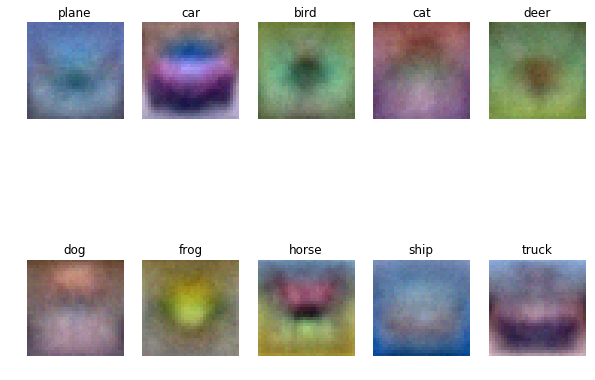

In [60]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])